In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import glob

In [37]:
from thash.tucker_hash import tucker_hash
from imagehash import average_hash, dhash, whash, phash
from PIL import Image
from itertools import combinations

In [58]:
from skimage import data, img_as_float, color, io
import matplotlib.pyplot as plt

In [45]:
hashes = {
    'dhash': dhash,
    'average_hash': average_hash,
    'tucker_hash': tucker_hash,
    'whash': whash,
    'phash': phash
}

In [26]:
def make_dataset(folder='./data/Pasadena-Houses/', img_format='jpg'):
    images = list()
    for _path in glob.glob(f'{folder}*.{img_format}'):
        images.append(Image.open(_path))
    return images

In [80]:
def bootstrap_prob(array, threshold, iteration=1000):
    probs = np.empty((iteration,))
    for i in range(iteration):
        sample = np.random.choice(array, size=array.shape)
        probs[i] = np.sum(sample < threshold) / array.shape[0]
    return np.mean(probs), np.percentile(probs, 2.5), np.percentile(probs, 97.5)

In [81]:
bootstrap_prob(np.random.normal(size=1000), 0)

(0.482287, 0.454, 0.512)

In [164]:
def hash_collision_test(hash_dict, dataset):
    labels = list()
    hash_array = dict()
    fig, (ax, ax_table) = plt.subplots(
        nrows=2, figsize = (10,15), gridspec_kw=dict(height_ratios=[3,1])
    )
    
    for hash_name, hash_func in hash_dict.items():
        img_comb = combinations(map(hash_func, dataset), 2)
        diff = list(map(lambda x: x[0] - x[1], img_comb))
        hash_array[hash_name] = np.array(diff) 
        sns.distplot(hash_array[hash_name], ax=ax)
        labels.append(hash_name)
    
    thresholds = [1, 2, 3, 4, 5]
    cellText = list()
    for hash_name, hash_array in hash_array.items():
        row = list()ist=False
        for thr in thresholds:
            mean, pr_1, pr_2 = bootstrap_prob(hash_array, thr)
            row.append(f'{mean:.2E}')
        cellText.append(row)
    
    ax.legend(labels=labels)
    ax.set_title('Hamming distance distrtibution')
    ax.set_xlabel('Hamming distance')

    ax_table.axis('off')
    ax_table.set_title('Probability of collisins for different thresholds')
    ax_table = ax_table.table(
        cellText=cellText, rowLabels=labels,
        colLabels=thresholds, loc='upper center'
    )
    plt.show()

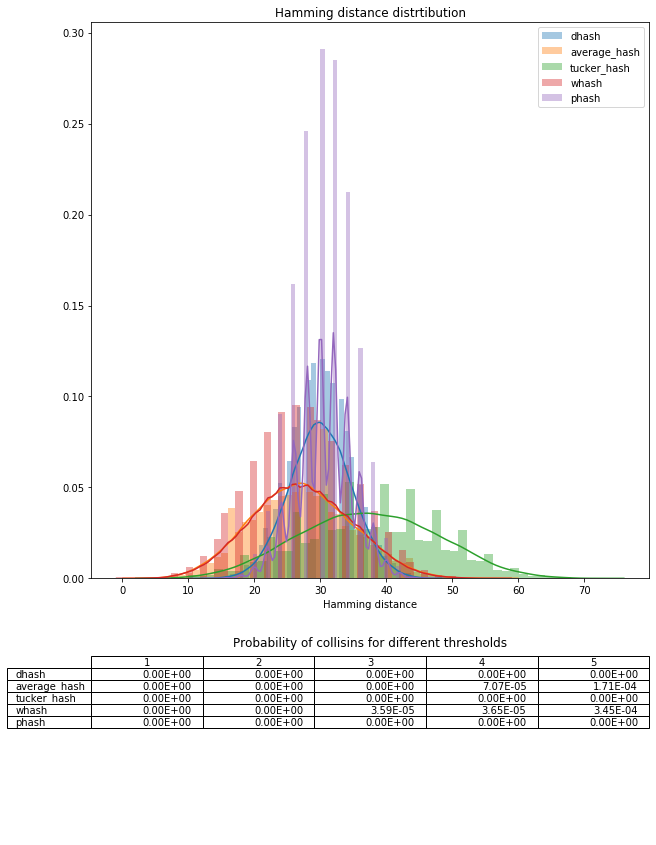

In [166]:
hash_collision_test(hashes, dataset)